In [1]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from model.ONN import ONNModel
from utils.loss_metrics import loss, grad, optimizer_init
from utils.utils_func import data_loader, _labelMapping, detector_regions


In [2]:
# load data
__, __, test_set, test_lab = data_loader(64)
# convert to tensors
tf_test_set = tf.convert_to_tensor(test_set, dtype=tf.complex64)
# load pretraiend model
pretrained_model = tf.keras.models.load_model("./saved_model/dataset_10000_epo_30")
pretrained_model.summary()

Model: "onn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 optical_layer (opticalLayer  multiple                 4096      
 )                                                               
                                                                 
 optical_layer_1 (opticalLay  multiple                 4096      
 er)                                                             
                                                                 
 optical_layer_2 (opticalLay  multiple                 4096      
 er)                                                             
                                                                 
 optical_layer_3 (opticalLay  multiple                 4096      
 er)                                                             
                                                                 
 optical_layer_4 (opticalLay  multiple                 40

In [9]:
# load variables
downsample = 4
distance = 25.14e-3 # plane spacing
lamb = 1565e-9 # wavelength
pixelSize = downsample*8e-6
Nx = int(256 / downsample) # 64
Ny = int(256 / downsample) # 64

In [14]:
def phase_confinement(phase):
    # according to X.lin et al, a sigmoid function is used to confine the phase value from 0 to 2*pi
    return tf.constant(2*np.pi, dtype=tf.float32) * tf.math.sigmoid(phase)

def phase_modulation(input, phase):
    imag_phi = tf.math.exp(1j*tf.cast(phase_confinement(phase), dtype = tf.complex64))
    return tf.math.multiply(input, imag_phi)

def tf_propagation(input, Nx, Ny, lamb, distance, pixelSize):
    # (@REF: "MPLC_StartHere.m" - J.Carpenter)
    # //TODO: how to setup k-space coordinate system? - DONE
    X = (tf.range(1, Ny+1, dtype=tf.float32)-Ny//2 - 0.5)*pixelSize
    Y = (tf.range(1, Nx+1, dtype=tf.float32)-Nx//2 - 0.5)*pixelSize

    [X, Y] = tf.meshgrid(X, Y)

    fs_x = Nx/(tf.math.reduce_max(X)-tf.math.reduce_min(X))
    fs_y = Ny/(tf.math.reduce_max(Y)-tf.math.reduce_min(Y))

    v_x = fs_x*(tf.range(-Nx/2, Nx/2, dtype=tf.float32)//Nx)
    v_y = fs_y*(tf.range(-Ny/2, Ny/2, dtype=tf.float32)//Ny)

    [V_X, V_Y] = tf.meshgrid(v_x, v_y)
    
    # Free-space transfer function
    sqr = tf.cast(tf.sqrt(1/lamb**2-V_X**2-V_Y**2), dtype=tf.complex64)
    tfcoef = tf.constant(-2j*np.pi*distance, dtype=tf.complex64)*sqr
    H = tf.exp(tfcoef*distance)

    # Free-space propagation
    input_fft = tf.signal.fftshift(tf.signal.fft2d(input))
    output = tf.signal.ifft2d(tf.signal.ifftshift(tf.multiply(H, input_fft)))

    return output

In [16]:
# testing layers
trained_vars = pretrained_model.trainable_variables 

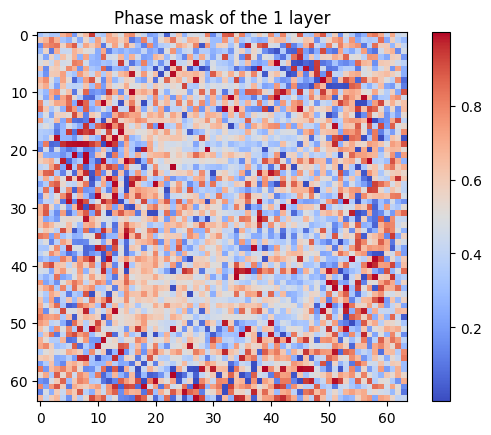

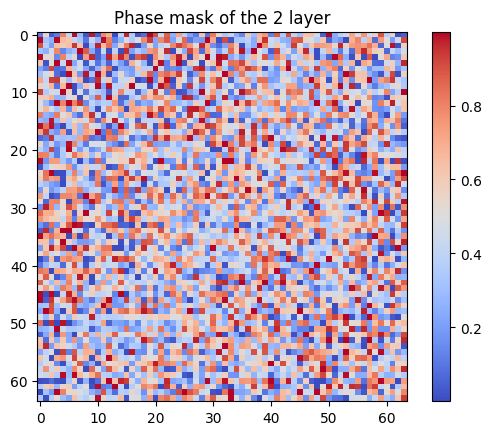

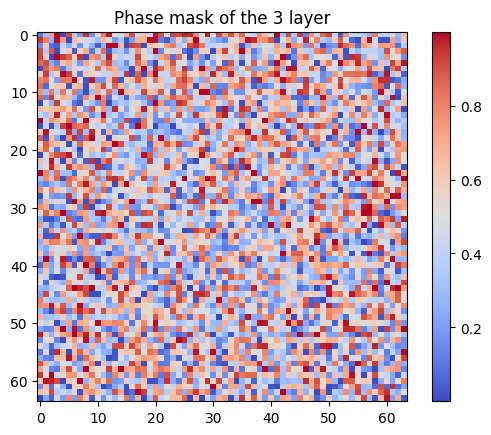

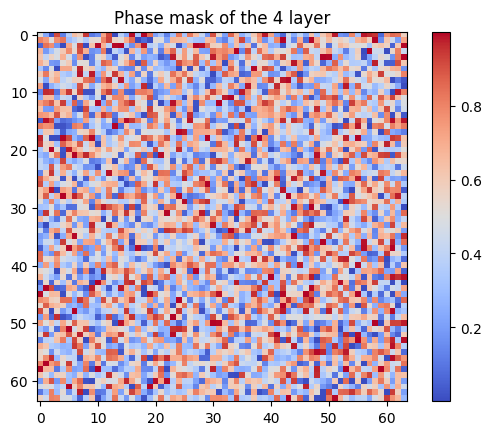

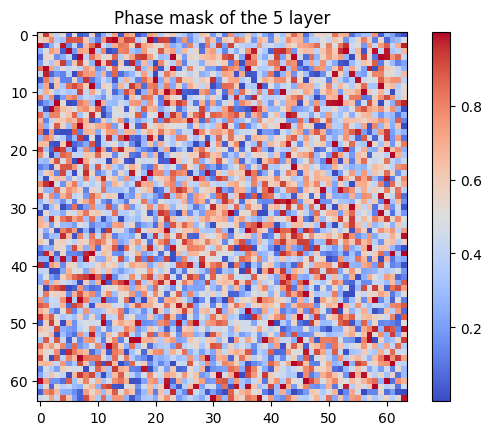

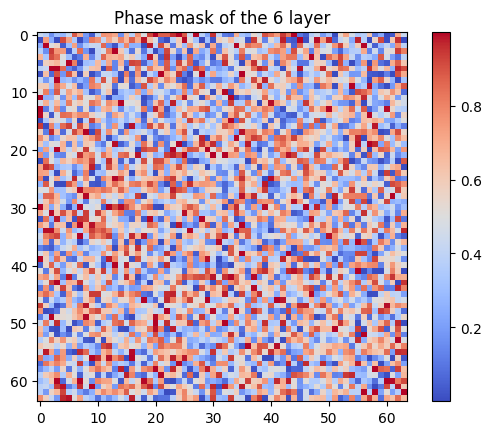

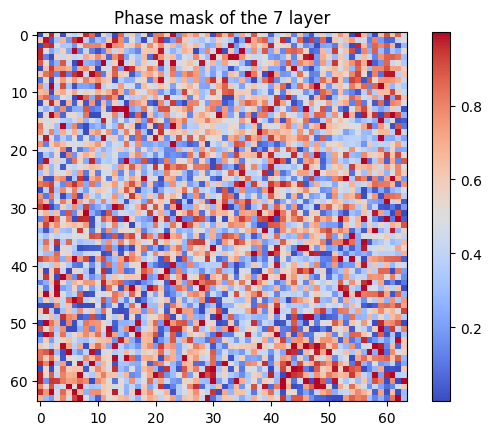

In [28]:
#display the phase masks
def sigmoid(x):
    return 1/(1+np.exp(-x))

for i in range(len(trained_vars)):
    layer_pha = sigmoid(np.array(trained_vars[i]))

    plt.figure()
    plt.imshow(layer_pha, cmap="coolwarm")
    plt.colorbar()
    plt.title(f"Phase mask of the {i+1} layer")
    plt.show()


### **Test the pretrained variables**

In [22]:
test_num = 2
test_img = tf_test_set[test_num]
test_out = pretrained_model(test_img, training=False)


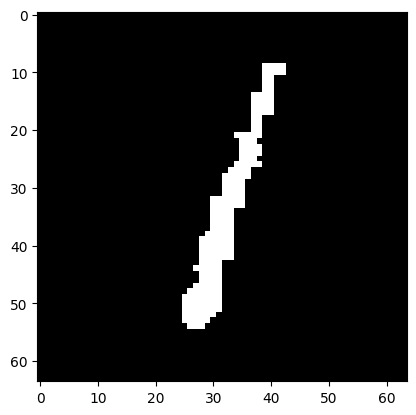

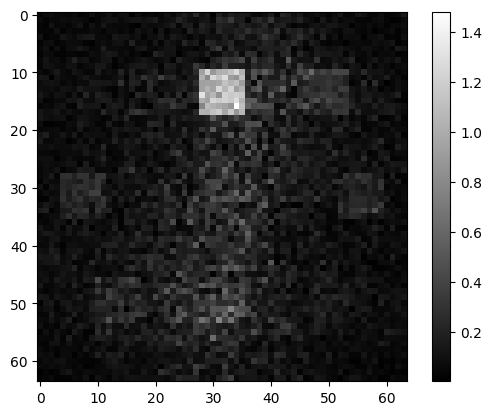

In [23]:
plt.figure()
plt.imshow(tf.abs(test_img), cmap="gray")
plt.figure()
plt.imshow(tf.abs(test_out), cmap="gray")
plt.colorbar()


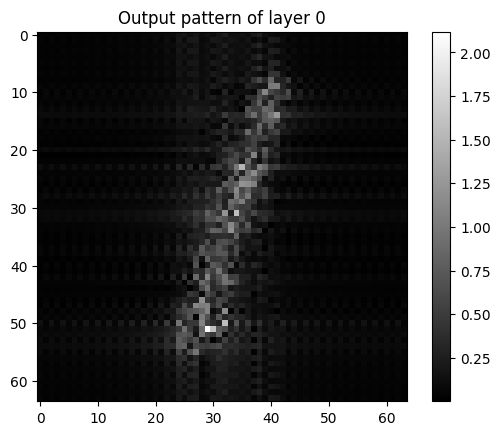

In [31]:
# Layer 0
input = tf.cast(tf.abs(test_img), dtype=tf.complex64)
phase_0 = trained_vars[0]

out_0 = tf_propagation(phase_modulation(input, phase_0), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_0), cmap="gray")
plt.title(f"Output pattern of layer 0")
plt.colorbar()

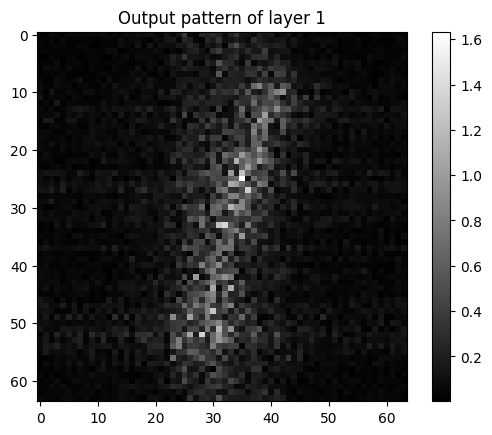

In [32]:
# Layer 1
phase_1 = trained_vars[1]

out_1 = tf_propagation(phase_modulation(out_0, phase_1), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_1), cmap="gray")
plt.title(f"Output pattern of layer 1")
plt.colorbar()

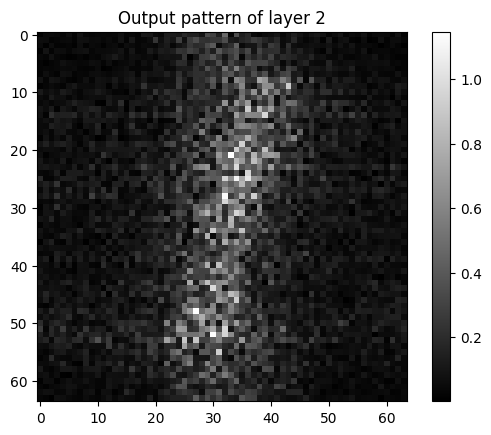

In [34]:
# Layer 2
phase_2 = trained_vars[2]

out_2 = tf_propagation(phase_modulation(out_1, phase_2), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_2), cmap="gray")
plt.title(f"Output pattern of layer 2")
plt.colorbar()

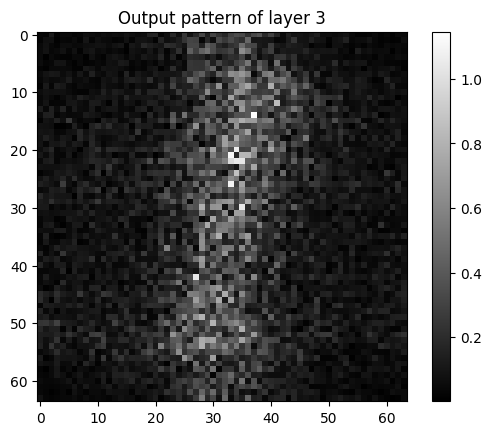

In [35]:
# Layer 3
phase_3 = trained_vars[3]

out_3 = tf_propagation(phase_modulation(out_2, phase_3), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_3), cmap="gray")
plt.title(f"Output pattern of layer 3")
plt.colorbar()

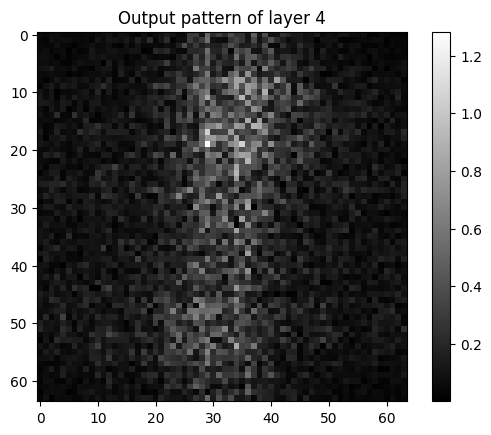

In [36]:
# Layer 4
phase_4 = trained_vars[4]

out_4 = tf_propagation(phase_modulation(out_3, phase_4), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_4), cmap="gray")
plt.title(f"Output pattern of layer 4")
plt.colorbar()

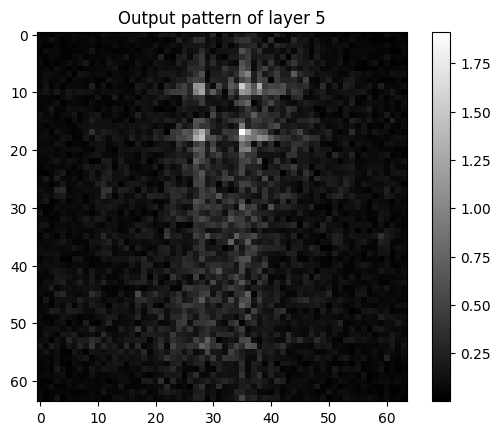

In [37]:
# Layer 5
phase_5 = trained_vars[5]

out_5 = tf_propagation(phase_modulation(out_4, phase_5), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_5), cmap="gray")
plt.title(f"Output pattern of layer 5")
plt.colorbar()

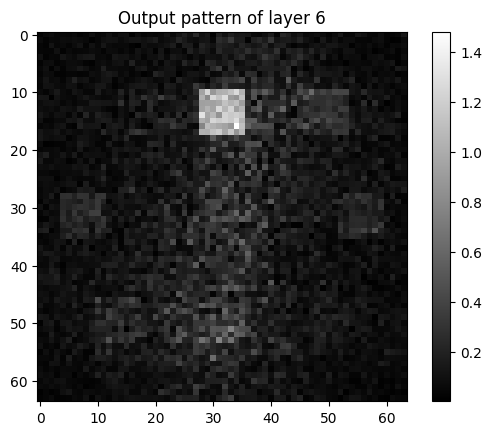

In [38]:
# Layer 6
phase_6 = trained_vars[6]

out_6 = tf_propagation(phase_modulation(out_5, phase_6), Nx, Ny, lamb, distance, pixelSize)

plt.figure()
plt.imshow(tf.abs(out_6), cmap="gray")
plt.title(f"Output pattern of layer 6")
plt.colorbar()